In [1]:
!pip install ultralytics==8.3.19
!pip install supervision[assets]==0.24.0
# !pip install inference

from IPython import display
display.clear_output()

In [2]:
from typing import Dict, Iterable, List, Optional, Set

import cv2
import numpy as np
from tqdm import tqdm
from ultralytics import YOLO

import supervision as sv

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [80]:
COLORS = sv.ColorPalette.from_hex(["#E6194B", "#3CB44B", "#FFE119", "#3C76D1"])
colors = sv.ColorPalette.DEFAULT

In [122]:
class VideoProcessor:
    def __init__(self,
        source_weights_path: str,
        source_video_path: str,
        target_video_path: Optional[str] = None,
        confidence_threshold: float = 0.3,
        iou_threshold: float = 0.7,
    ) -> None:
        self.conf_threshold = confidence_threshold
        self.iou_threshold = iou_threshold
        self.source_video_path = source_video_path
        self.target_video_path = target_video_path

        self.model = YOLO(source_weights_path)
        self.tracker = sv.ByteTrack()

        self.video_info = sv.VideoInfo.from_video_path(source_video_path)

        self.polygons = [
            np.array([(0, 171), (704, 171), (704, 392), (0, 392)]), 
            np.array([(0, 693), (708, 693), (708, 914), (0, 914)]),
            np.array([(1239, 177), (1920, 177), (1920, 393), (1239, 393)]),
            np.array([(1244, 692), (1920, 692), (1920, 914), (1244, 914)])
        ]

        self.zones = [
            sv.PolygonZone(polygon=polygon) for polygon in polygons
        ]

        self.zone_annotators = [
            sv.PolygonZoneAnnotator(
                zone=zone,
                color=colors.by_idx(index),
                thickness=4,
                text_thickness=8,
                text_scale=4
            )
            for index, zone in enumerate(self.zones)
        ]
        
        self.box_annotators = [
            sv.BoxAnnotator(
                color=colors.by_idx(index),
                thickness=4,
            )
            for index in range(len(self.polygons))
        ]
        
        self.trace_annotators = [
            sv.TraceAnnotator(
                color=colors.by_idx(index), 
                position=sv.Position.CENTER, 
                trace_length=100, 
                thickness=2
            ) for index in range(len(self.polygons))
        ]
        
        self.color_annotators = [
            sv.ColorAnnotator(
                color=colors.by_idx(index)
            )
            for index in range(len(self.polygons))
        ]

        self.label_annotator = sv.LabelAnnotator(
            text_color=sv.Color.BLACK
        )

        
    def process_video(self):
        frame_generator = sv.get_video_frames_generator(
            source_path=self.source_video_path
        )
        with sv.VideoSink(self.target_video_path, self.video_info) as sink:
            for frame in tqdm(frame_generator, total=self.video_info.total_frames):
                annotated_frame = self.process_frame(frame)
                sink.write_frame(annotated_frame)

    def annotate_frame(self, frame: np.ndarray, detections: sv.Detections) -> np.ndarray:
        annotated_frame = frame.copy()
        labels = [
            f"{tracker_id}" for tracker_id in detections.tracker_id
        ]
        annotated_frame = self.label_annotator.annotate(annotated_frame, detections, labels)
        
        for zone, zone_annotator, box_annotator, color_annotator, trace_annotator in zip(self.zones, self.zone_annotators, self.box_annotators, self.color_annotators, self.trace_annotators):
            mask = zone.trigger(detections=detections)
            detections_filtered = detections[mask]
            # annotated_frame = box_annotator.annotate(scene=annotated_frame, detections=detections_filtered)
            annotated_frame = color_annotator.annotate(scene=annotated_frame, detections=detections_filtered)
            annotated_frame = trace_annotator.annotate(scene=annotated_frame, detections=detections_filtered)
            annotated_frame = zone_annotator.annotate(scene=annotated_frame)
        
        return annotated_frame

    def process_frame(self, frame: np.ndarray) -> np.ndarray:
        result = self.model(frame, verbose=False, conf=self.conf_threshold, iou=self.iou_threshold)[0]
        detections = sv.Detections.from_ultralytics(result)
        detections = self.tracker.update_with_detections(detections) #detection with tracker_id

        detections_in_zones = [] #tạo list rỗng chứa các detection trong các zone

        for zone in self.zones:
            mask = zone.trigger(detections=detections) #duyệt và thêm các detection trong từng zone vào list
            detections_in_one_zone = detections[mask]
            detections_in_zones.append(detections_in_one_zone)
        detections = sv.Detections.merge(detections_in_zones)
        return self.annotate_frame(frame, detections) #chỉ annotate các detection trong zone

In [123]:
source_weights_path = '/kaggle/input/traffic_analysis/pytorch/default/1/traffic_analysis.pt'
source_video_path = '/kaggle/input/crossroads/City busy traffic intersection time lapse  _ Free Full HD Video - no copyright.mp4'
target_video_path = '/kaggle/working/output.mp4'
confidence_threshold = 0.3
iou_threshold = 0.7

In [124]:
processor = VideoProcessor(source_weights_path, source_video_path, target_video_path)
processor.process_video()

100%|██████████| 480/480 [00:31<00:00, 15.28it/s]


## Experiments

In [24]:
model = YOLO('/kaggle/input/traffic_analysis/pytorch/default/1/traffic_analysis.pt')

CLASS_NAMES_DICT = model.model.names
SELECTED_CLASS_NAMES = ['person']
SELECTED_CLASS_IDS = [{value: key for key, value in CLASS_NAMES_DICT.items()}[class_name] for class_name in SELECTED_CLASS_NAMES]
COLORS = sv.ColorPalette.from_hex(["#E6194B", "#3CB44B", "#FFE119", "#3C76D1"])

In [25]:
SOURCE_VIDEO_PATH = '/kaggle/input/crossroads/City busy traffic intersection time lapse  _ Free Full HD Video - no copyright.mp4'

In [86]:
colors = sv.ColorPalette.DEFAULT

# Generate frames from the input video file
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

# Create an instance of LabelAnnotator for displaying labels on detections
label_annotator = sv.LabelAnnotator(
    text_thickness=1,
    text_scale=1,
    text_color=sv.Color.BLACK
)

polygons = [
    np.array([(0, 171), (704, 171), (704, 392), (0, 392)]), 
    np.array([(0, 693), (708, 693), (708, 914), (0, 914)]),
    np.array([(1239, 177), (1920, 177), (1920, 393), (1239, 393)]),
    np.array([(1244, 692), (1920, 692), (1920, 914), (1244, 914)])
]
zones = [sv.PolygonZone(polygon=polygon) for polygon in polygons]

box_annotators = [
    sv.BoundingBoxAnnotator(
        color=colors.by_idx(index),
        thickness=4,
    )
    for index
    in range(len(polygons))
]

color_annotators = [
    sv.ColorAnnotator(
        color=colors.by_idx(index)
    )
    for index, zone
    in enumerate(zones)
]

zone_annotators = [
    sv.PolygonZoneAnnotator(
        zone=zone,
        color=colors.by_idx(index),
        thickness=4,
        text_thickness=8,
        text_scale=4
    )
    for index, zone
    in enumerate(zones)
]

trace_annotators = [sv.TraceAnnotator(
            color=colors.by_idx(index), 
            position=sv.Position.CENTER, 
            trace_length=100, 
            thickness=1
        ) for index in range(len(polygons))
]

SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


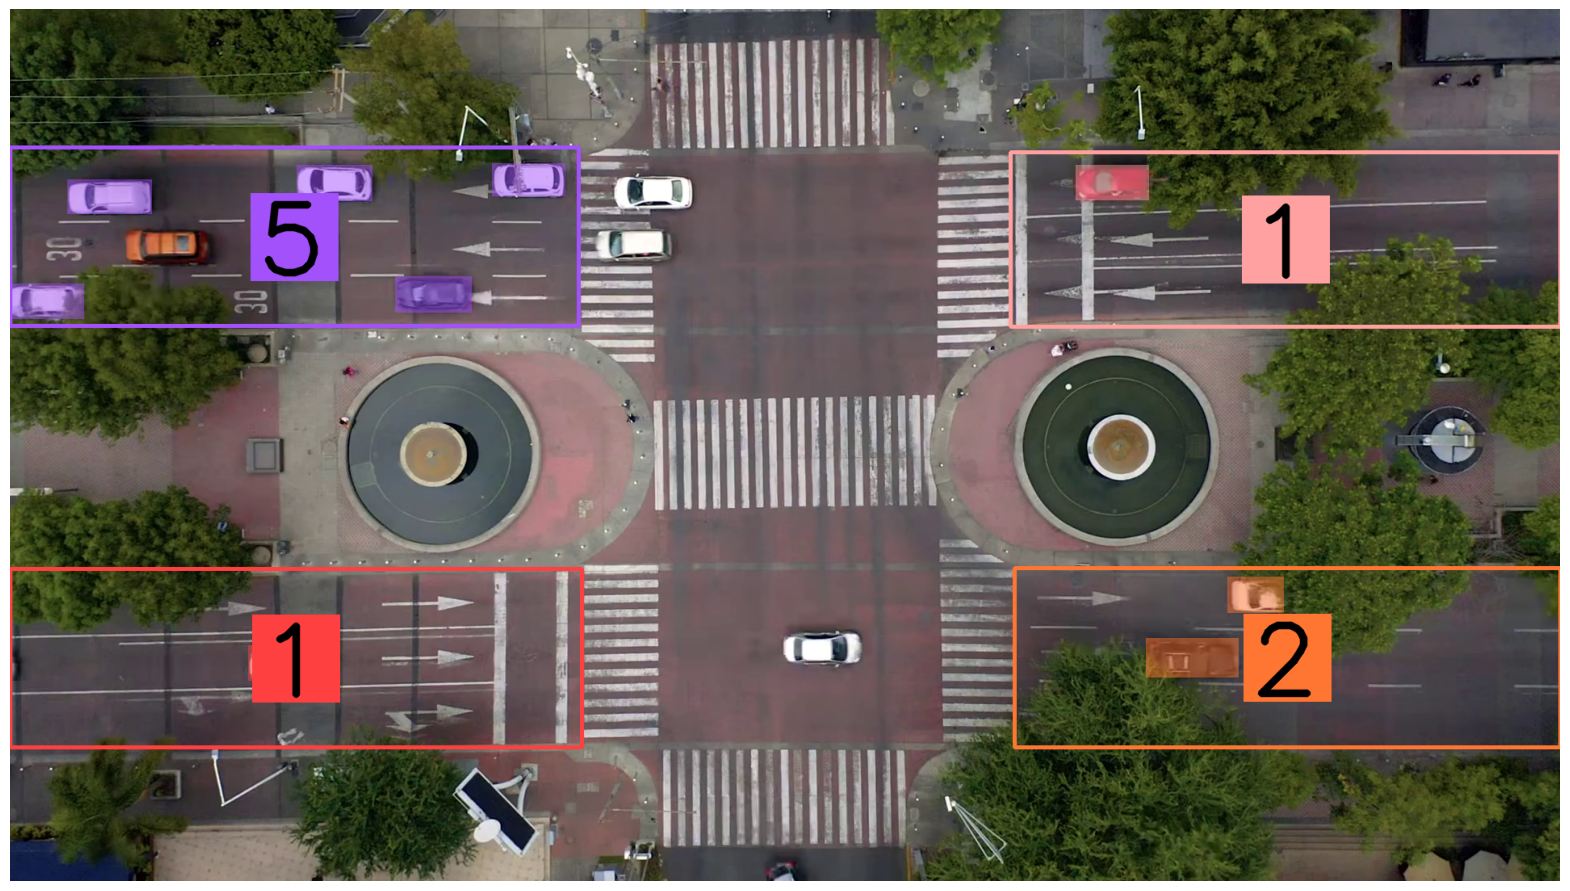

In [78]:
iterator = iter(generator)

# Retrieve the first frame from the video
frame = next(iterator)

# Run the YOLO model on the frame to detect objects
results = model(frame, verbose=False)[0]

# Convert YOLO detection results to a Supervision Detections object
detections = sv.Detections.from_ultralytics(results)

# Filter detections to keep only the selected class IDs (car, motorcycle, bus, truck)
# detections = detections[np.isin(detections.class_id, SELECTED_CLASS_IDS)]

# Generate labels for detected objects in the format "class_name confidence"
labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
    for confidence, class_id in zip(detections.confidence, detections.class_id)
]

# Create a copy of the frame to apply annotations
annotated_frame = frame.copy()

for zone, zone_annotator, box_annotator, color_annotator in zip(zones, zone_annotators, box_annotators, color_annotators):
    mask = zone.trigger(detections=detections)
    detections_filtered = detections[mask]
    annotated_frame = box_annotator.annotate(scene=frame, detections=detections_filtered)
    annotated_frame = color_annotator.annotate(scene=frame, detections=detections_filtered)
    annotated_frame = zone_annotator.annotate(scene=frame)
    annotated_frame = label_annotator.annotate()

# Display the annotated frame with bounding boxes and labels
sv.plot_image(annotated_frame, (20, 20))